## Load python lib

In [1]:
!pip install markdown
!pip install kaleido
!pip install -U sentence-transformers rank_bm25

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 76.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.2 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=c89ad6b7d7407b3c4bf9dc96bac3ce6c51355f71b07de65bce9426943eb65e5b
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [2]:
import kaleido
import markdown
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="pandas")

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)


In [3]:
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/gdrive')
import pandas as pd
import csv
import io
import concurrent.futures
from tqdm.auto import tqdm
import os
import re
import torch

from rank_bm25 import BM25Okapi
from sklearn.feature_extraction import _stop_words
import string
from tqdm.autonotebook import tqdm
import numpy as np

from sklearn.manifold import TSNE


Mounted at /content/gdrive


In [ ]:
import torch

deps = ["datasets" ,"sentence-transformers", "rich['jupyter']", "requests"]
if torch.cuda.is_available():
    deps.append("faiss-gpu")
else:
    deps.append("faise-cpu")

!pip install huggingface_hub
!pip install rich
!pip install {" ".join(deps)} --upgrade

from huggingface_hub import hf_api
import requests
import pandas as pd
import matplotlib.pyplot as plt
import rich
import json
import re
import ast
from collections import Counter
%matplotlib inline
plt.style.use("ggplot")
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', None)
import datetime as dt
from collections import defaultdict
import pickle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.8/239.8 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 37.9 MB/s eta 0:00:00
  Attempting uninstall: rich
    Found existing installation: rich 13.5.2
    Uninstalling rich-13.5.2:
      Successfully uninstalled rich-13.5.2


In [ ]:
import json
from sentence_transformers import SentenceTransformer, CrossEncoder, util
import gzip
import os
import torch

if not torch.cuda.is_available():
    print("Warning: No GPU found. Please add GPU to your notebook")



## Load Data

In [ ]:
import pandas as pd

def string_to_list( input_string):
    if type(input_string) != str: return[]
    if input_string[0] != '[': return [input_string]
    return ast.literal_eval(input_string)

data_full = pd.read_csv("/content/gdrive/MyDrive/final project results/model_EDA_final_2.csv")
columns_to_keep = ['modelId', 'downloads','readme']
data_full = data_full[columns_to_keep]

In [ ]:
data = pd.read_csv("/content/gdrive/MyDrive/final project results/model_preprocessed_by_Chaim.csv")
data = data.drop(columns=['col_to_embedd'])


In [ ]:
data.columns

Index(['Unnamed: 0', 'index', 'id', 'labels_col', 'datasets', 'pipeline_tag'], dtype='object')

In [ ]:
# Perform a left join on 'id' and 'modelId'
data = data.merge(data_full, left_on='id', right_on='modelId', how='left')
data['downloads'] = data['downloads'].fillna(0)  # Fill missing values with 0 if needed
data['col_to_embedd']  = data["readme"]
data = data.drop(columns=['modelId'])

In [ ]:
def remove_substrings(input_string, substrings):
    for substring in substrings:
        input_string = input_string.replace(substring, "")
    return input_string


def capture_name_basis(input_str):
  replace_size_params = ["-base",'-tiny',"-medium","-small","-large","-xl","-xs","xlm","-v0",'-v1',"-v2","v3","-v4","-updated","-finetuned","-uncased" ,"7b","13b"]
  replace_size_params_underscore = ["_base",'_tiny',"_medium","_small","_large","_xl","_xs","_xlm","_v0",'-v1',"-v2","_v3","_v4","-updated","_finetuned","_uncased"]
  result = remove_substrings(input_str, replace_size_params)
  result = remove_substrings(result, replace_size_params_underscore)
  result = result.replace('_', '-')
  parts = (result).split("-")
  if len(parts) == 1 or len(parts) ==2:
    return "-".join(parts)
  if len(parts) ==3:
     result = "-".join(parts)[:-2]
     return result
  if len(parts) > 3:
     result = "-".join(parts[0:4])
     return result[:-2]

data["name_basis"] = data["id"].apply(capture_name_basis)


In [ ]:
data.columns

Index(['Unnamed: 0', 'index', 'id', 'labels_col', 'datasets', 'pipeline_tag',
       'downloads', 'readme', 'col_to_embedd', 'name_basis'],
      dtype='object')

## create eval set

In [ ]:
# textual_queries = [
#     ("facebook/musicgen-small", " is a music generation model offering different sizes (300M, 1.5B, 3.3B parameters) and two specialized variants: one for text-to-music generation and another for melody-guided music generation. It comprises an EnCodec model for audio tokenization and an auto-regressive transformer-based language model. Supported tasks include text-to-music generation and melody-guided music generation."),
#     ("stabilityai/stable-diffusion-xl-base-1.0", "A SOTA model which generates images and artwork according to textual prompts. The model can also modify existing images."),
#     ("meta-llama/Llama-2-7b", "Generative text model trained by Meta optimized for dialogues or conversations."),
#     ("openai/whisper-large-v2", "Pre-trained model for automatic speech recognition (ASR) and speech translation, which supports multilingual data."),
#     ("intfloat/multilingual-e5-large", "Text embeddings model trained to support multilingual text."),
#     ("human-centered-summarization/financial-summarization-pegasus", "Towards Human-Centered Summarization: A Case Study on Financial News. In Proceedings of the First Workshop on Bridging Human-Computer Interaction and Natural Language Processing."),
#     ("foduucom/stockmarket-pattern-detection-yolov8", "Market Pattern Detection on Live Trading Video Data."),
#     ("apanc/russian-inappropriate-messages", "This model is trained on a dataset of inappropriate messages in the Russian language. It identifies utterances that may harm the speaker's reputation but do not necessarily contain obscene words or toxic intent."),
#     ("defog/sqlcoder", "Natural Language to SQL Conversion."),
#     ("bigcode/starcoder", "Language model (LM) trained on source code and natural language text. Supports code generation."),
#     ("allenai/aspire-biencoder-biomed-scib", "This model is a BERT bi-encoder trained to assess the similarity of title-abstract pairs in biomedical scientific papers. It was trained on pairs of co-cited papers in a contrastive learning setup."),
#     ("kha-white/manga-ocr-base", "Printed Japanese OCR text recognition."),
#     ("dbmdz/bert-base-historic-multilingual-cased", "Historical language model that supports multiple languages."),
#     ("mrm8488/codebert-base-finetuned-detect-insecure-code", "Given a source code, identify whether it is insecure code that may attack software systems, such as resource leaks, use-after-free vulnerabilities, and DoS attacks. Treat task as binary classification (0/1), where 1 represents insecure code and 0 represents secure code.")
# ]

textual_queries = [
     ("monster-labs/control_v1p_sd15_qrcode_monster", "model which generates colourful qr codes for scannning"),
     ("human-centered-summarization/financial-summarization-pegasus", "Towards Human-Centered Summarization: A Case Study on Financial News. In Proceedings of the First Workshop on Bridging Human-Computer Interaction and Natural Language Processing."),
     ("defog/sqlcoder", "Natural Language to SQL Conversion."),
     ("allenai/aspire-biencoder-biomed-scib", "This model is a BERT bi-encoder trained to assess the similarity of title-abstract pairs in biomedical scientific papers. It was trained on pairs of co-cited papers in a contrastive learning setup."),
      ("kha-white/manga-ocr-base", "Printed Japanese OCR text recognition."),
      ("foduucom/stockmarket-pattern-detection-yolov8", "Market Pattern Detection on Live Trading Video Data."),
     ("apanc/russian-inappropriate-messages", "This model is trained on a dataset of inappropriate messages in the Russian language. It identifies utterances that may harm the speaker's reputation but do not necessarily contain obscene words or toxic intent."),
     ("sander-wood/text-to-music", "generate music according to a textual prompt")]


In [ ]:
lst_model = []
for model_name , model_desc in textual_queries:
  lst_model.append(data[data["id"]==model_name]["name_basis"].iloc[0])
lst_model

['monster-labs/control-v1p-sd',
 'human-centered-summarization/financial-summarizati',
 'defog/sqlcoder',
 'allenai/aspire-biencoder-biomed-sc',
 'kha-white/manga-o',
 'foduucom/stockmarket-pattern-detection-yolo',
 'apanc/russian-inappropriate-messag',
 'sander-wood/text-to-mus']

### Remove duplicates (same name root or same readme)

In [ ]:
# Deduplicate
data.sort_values(by="downloads", ascending=False, inplace=True)

print(data.shape[0])
data.drop_duplicates(subset="col_to_embedd", keep="first", inplace=True)

print(data.shape[0])
data.drop_duplicates(subset="name_basis", keep="first", inplace=True)
print(data.shape[0])

data.reset_index(drop=True, inplace=True)


52843
39820
33511


In [ ]:
textual_queries = dict()
for name_basis in lst_model:
    model_id = data[data["name_basis"] == name_basis]["id"].iloc[0]
    textual_queries[model_id] = ""
textual_queries

{'monster-labs/control_v1p_sd15_qrcode_monster': '',
 'human-centered-summarization/financial-summarization-pegasus': '',
 'defog/sqlcoder': '',
 'allenai/aspire-biencoder-biomed-scib': '',
 'kha-white/manga-ocr-base': '',
 'foduucom/stockmarket-pattern-detection-yolov8': '',
 'apanc/russian-inappropriate-messages': '',
 'sander-wood/text-to-music': ''}

### preprocess for basic modeling

In [ ]:
data["id"] = data["id"].astype(str)
data["col_to_embedd"] = data["col_to_embedd"].astype(str)
data['paragraphs']= data["col_to_embedd"]

data["datasets"] = data["datasets"].apply(string_to_list)
data["labels_col"] = data["labels_col"].apply(string_to_list)

passages = data['paragraphs'].tolist()
model_id_lst = data['id'].tolist()

## Init models

In [ ]:
def encode_results_bi_encoder(input_model_path, pickle_file_path= '/content/gdrive/MyDrive/corpus_embedding_trained_weighted_triplets.pickle'):
  bi_encoder = SentenceTransformer(input_model_path)
  bi_encoder.max_seq_length = 400
  top_k = 32
  print("Passages:", len(passages))
  corpus_embeddings = bi_encoder.encode(passages, convert_to_tensor=True, show_progress_bar=True)
  with open(pickle_file_path, 'wb') as file:
      pickle.dump(pickle_file_path, file)
  return bi_encoder, corpus_embeddings

def bm25_tokenizer(text):
    tokenized_doc = []
    for token in text.split():
        token = token.strip(string.punctuation)

        if len(token) > 0 and token not in _stop_words.ENGLISH_STOP_WORDS:
            tokenized_doc.append(token)
    return tokenized_doc

def encode_bm25(passages):
  tokenized_corpus = []
  for passage in tqdm(passages):
      tokenized_corpus.append(bm25_tokenizer(passage))
  bm25 = BM25Okapi(tokenized_corpus)
  return bm25


In [ ]:

# corpus_embeddings = bi_encoder_trained.encode(passages, convert_to_tensor=True, show_progress_bar=True)

In [ ]:

def bm25_search(query, bm25, bm25_tokenizer, model_id_lst, passages):
    bm25_scores = bm25.get_scores(bm25_tokenizer(query))
    top_n = np.argpartition(bm25_scores, -5)[-5:]
    bm25_hits = [{'corpus_id': idx, 'score': bm25_scores[idx]} for idx in top_n]
    bm25_hits = sorted(bm25_hits, key=lambda x: x['score'], reverse=True)

def semantic_search(query, bi_encoder, corpus_embeddings, top_k):
    # Encode the query using the bi-encoder and find potentially relevant passages
    question_embedding = bi_encoder.encode(query, convert_to_tensor=True)
    question_embedding = question_embedding.cuda()
    hits = util.semantic_search(question_embedding, corpus_embeddings, top_k=top_k)
    hits = hits[0]  # Get the hits for the first query
    return hits

def cross_encoder_rerank(query, hits, cross_encoder, model_id_lst, passages):
    # Now, score all retrieved passages with the cross_encoder
    cross_inp = [[query, passages[hit['corpus_id']]] for hit in hits]
    cross_scores = cross_encoder.predict(cross_inp)

    # Sort results by the cross-encoder scores
    for idx in range(len(cross_scores)):
        hits[idx]['cross-score'] = cross_scores[idx]
    hits = sorted(hits, key=lambda x: x['cross-score'], reverse=True)
    return hits

def search_items(query, id_name, bi_encoder, bm25, bm25_tokenizer, corpus_embeddings, cross_encoder, model_id_lst, passages, top_k=10):
    print("Input question:", query)
    bm25_search(query, bm25, bm25_tokenizer, model_id_lst, passages)
    hits = semantic_search(query, bi_encoder, corpus_embeddings, top_k)
    hits = cross_encoder_rerank(query, hits, cross_encoder, model_id_lst, passages)


## Get Bi-encoder recomendations

In [ ]:

def retrieve_reccomendations_same_objects(model, ds_query_embeddings ,ds_target_embeddings, df_query, k):
    recommendations_and_ground_truth = dict()
    raw_recommendations = util.semantic_search(torch.Tensor(ds_query_embeddings), torch.Tensor(ds_target_embeddings))
    for index, recommendations_list in enumerate(raw_recommendations):
        print(f"retriveing recommendations for index {index}/{ds_query_embeddings.shape[0]}", end='\r')
        query_id = df_query.iloc[index]['id']
        recommendations_id = [df_query.iloc[recommendation['corpus_id']]['id'] for recommendation in recommendations_list]
        recommendations_labels = [df_query.iloc[recommendation['corpus_id']]['labels_col'] for recommendation in recommendations_list]
        ground_truth = df_query[df_query["id"]==query_id]["labels_col"].iloc[0]
        recommendations_and_ground_truth[query_id] = (recommendations_id, recommendations_labels, ground_truth)
    return recommendations_and_ground_truth

## evaluation func

In [ ]:

def percentage_label_intersections(label_set_recommended, label_set_grount_truth):
    if len(label_set_recommended) ==0 or len(label_set_grount_truth)==0:
      return 0 , 0 , 0 ,0
    else:
      counts = np.zeros(len(label_set_recommended))
      inverse_weights = 1 / np.log2(1 + np.arange(2, len(counts) + 2))
      for i, label_set in enumerate(label_set_recommended):

          intersection_set = set(label_set) & set(label_set_grount_truth)
          counts[i] = len(intersection_set) / min(len(label_set), len(label_set_grount_truth))
      return counts.max(), counts.mean(), counts.min() ,np.average(counts, weights=inverse_weights)

def count_label_intersections(label_set_recommended, label_set_grount_truth):
    if len(label_set_recommended) ==0 or len(label_set_grount_truth)==0:
      return 0 , 0 , 0, 0
    else:
      counts = np.zeros(len(label_set_recommended))
      inverse_weights = 1 / np.log2(1 + np.arange(2, len(counts) + 2))
      for i, label_set in enumerate(label_set_recommended):
          intersection_set = set(label_set) & set(label_set_grount_truth)
          counts[i] = len(intersection_set)
      return counts.max(), counts.mean(), counts.min() ,np.average(counts, weights=inverse_weights)

def evaluate_by_intersection_size(retrieveed_reccomendations: dict, func_label_intersection) -> pd.DataFrame:
    ks = [1, 3, 5, 10, 20, 50, 100]
    # ks = [ 10]
    res_intersection_max = np.zeros((len(retrieveed_reccomendations), len(ks)))
    res_intersection_mean = np.zeros((len(retrieveed_reccomendations), len(ks)))
    res_intersection_min = np.zeros((len(retrieveed_reccomendations), len(ks)))
    res_intersection_weighted = np.zeros((len(retrieveed_reccomendations), len(ks)))

    for i, (id, (recomendation_id, recommendations_labels, ground_truth)) in enumerate(retrieveed_reccomendations.items()):
        for j, k in enumerate(ks):
            k = min(len(ground_truth), k, len(recommendations_labels))
            intersection_max, intersection_mean, intersection_min , intersection_weighted = func_label_intersection(recommendations_labels[:k], ground_truth[:k])
            res_intersection_max[i, j] = intersection_max
            res_intersection_mean[i, j] = intersection_mean
            res_intersection_min[i, j] = intersection_min
            res_intersection_weighted[i,j] = intersection_weighted

    data = [res_intersection_max.mean(axis=0), res_intersection_mean.mean(axis=0), res_intersection_min.mean(axis=0),res_intersection_weighted.mean(axis=0)]
    index = ['intersection_max', 'intersection_mean', 'intersection_min', "intersection_weighted"]
    columns = [f"k={k}" for k in ks]
    res = pd.DataFrame(data=data, columns=columns, index=index)
    return res


def evaluate_by_dcg(retrieveed_reccomendations: dict, func_label_intersection) -> pd.DataFrame:
    ks = [ 5]
    dcg_values = []
    for i, (id, (recomendation_id, recommendations_labels, ground_truth)) in enumerate(retrieveed_reccomendations.items()):
        for j, k in enumerate(ks):
            k = min(len(ground_truth), k, len(recommendations_labels))
            dcg_at_k = dcg_at_k(recommendations_labels[:k], ground_truth, k)
            dcg_values.append(dcg_at_k)
    mean_dcg = np.mean(np.array(dcg_values))
    print(f"mean dcg: {mean_dcg}")
    return mean_dcg

def dcg_at_k(label_set_recommended,label_set_grount_truth,  k):
  if len(label_set_recommended) ==0 or len(label_set_grount_truth)==0:
      return 0
  else:
    relevance_score = np.zeros(len(label_set_recommended))
    for i, label_set in enumerate(label_set_recommended):
        intersection_set = set(label_set) & set(label_set_grount_truth)
        relevance_score[i] = len(intersection_set)
  relevance_scores = np.asarray(relevance_score)
  relevance_scores = relevance_scores[:k]
  if len(relevance_scores) ==0:
    return 0
  dcg = np.sum(relevance_scores / np.log2(np.arange(2, len(relevance_scores) + 3)))
  return dcg

def single_res_label_intersection(label_set_recommended, label_set_grount_truth):
    counts = np.zeros(len(label_set_recommended))
    if len(label_set_recommended) ==0 or len(label_set_grount_truth)==0:
      return counts
    for i, label_set in enumerate(label_set_recommended):
        intersection_set = set(label_set) & set(label_set_grount_truth)
        counts[i] = len(intersection_set)/ min(len(label_set), len(label_set_grount_truth))
    return counts

## plotting functions

In [ ]:
import plotly.graph_objects as go

def plot_evaluations_percent(evaluation_md_to_md, out_path, model_name):
    fig3 = go.Figure()
    fig3.add_trace(go.Bar(x=evaluation_md_to_md.columns, y=evaluation_md_to_md.iloc[0].values, name="max intersection", showlegend=True))
    fig3.add_trace(go.Bar(x=evaluation_md_to_md.columns, y=evaluation_md_to_md.iloc[1].values, name="mean intersection", showlegend=True))
    fig3.add_trace(go.Bar(x=evaluation_md_to_md.columns, y=evaluation_md_to_md.iloc[2].values, name="min intersection", showlegend=True))
    fig3.update_layout(title=f"mean intersection size \t{model_name}", yaxis_range=[0,1])
    fig3.write_image(out_path, engine='kaleido')
    fig3.show()

def plot_evaluations_count(evaluation_md_to_md, out_path, model_name):
    fig3 = go.Figure()
    fig3.add_trace(go.Bar(x=evaluation_md_to_md.columns, y=evaluation_md_to_md.iloc[0].values, name="max intersection", showlegend=True))
    fig3.add_trace(go.Bar(x=evaluation_md_to_md.columns, y=evaluation_md_to_md.iloc[1].values, name="mean intersection", showlegend=True))
    fig3.add_trace(go.Bar(x=evaluation_md_to_md.columns, y=evaluation_md_to_md.iloc[2].values, name="min intersection", showlegend=True))
    fig3.update_layout(title=f"mean intersection size \t{model_name}", yaxis_range=[0,10])
    fig3.write_image(out_path, engine='kaleido')
    fig3.show()


In [ ]:

def plot_heatmap(results_df,plot_name , output_path):
    # Create a heatmap
    sns.set()
    plt.figure(figsize=(16, 10))
    stacked_array = np.vstack(results_df[ "Intersection"])
    sns.heatmap(pd.DataFrame(stacked_array),cmap='Greens' ,annot=False , yticklabels= results_df["Model"].to_list())
    # Add labels and a title
    plt.xlabel('Ranked reccomendation')
    plt.title(plot_name)
    plt.savefig(output_path, dpi=300)
    plt.show()


## results

In [ ]:
def display_query_res(textual_queries, retrieved_recommendations):
    results_data = []
    GREEN = "\033[92m"
    RESET = "\033[0m"

    for model_id, query in textual_queries.items():
        try:
            print(f"{GREEN}Model {model_id}:{RESET}")
            if model_id in retrieved_recommendations:
                recommendation_id, recommendations_labels, ground_truth = retrieved_recommendations[model_id]
                result = recommendation_id[1:6]
                result = "\n".join(result)
                print(result)
                intersection = single_res_label_intersection(recommendations_labels, ground_truth)
                results_data.append({'Model': model_id, 'Intersection': intersection[1:], 'Ranked Results': recommendation_id[1:]})
            else:
                print(f"No recommendations found for model {model_id}")
        except Exception as e:
            print(f"Error processing model {model_id}: {str(e)}")

    results_df = pd.DataFrame(results_data)
    return results_df



In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE

def replace_if_not_allowed(value):
    allowed_values = ["text-generation", "automatic-speech-recognition", "image-classification"]
    if value not in allowed_values:
        return "other"
    return value

def create_tsne_scatter_plot(data, corpus_embeddings, model_name, output_path):
    top_200 = data.iloc[:1000, :]
    top_200_emb = corpus_embeddings[:1000].cpu()
    tsne = TSNE(random_state=1, n_iter=15000, metric="cosine")

    tsne_embs = tsne.fit_transform(top_200_emb)
    top_200['x'] = tsne_embs[:, 0]
    top_200['y'] = tsne_embs[:, 1]

    allowed_values = ["text-generation", "automatic-speech-recognition", "image-classification"]

    top_200['pipeline_tag'] = top_200['pipeline_tag'].apply(replace_if_not_allowed)

    fig, ax = plt.subplots()
    for tag, group in top_200.groupby('pipeline_tag'):
        ax.scatter(group['x'], group['y'], label=tag, alpha=0.5)

    #ax.legend(title='Pipeline Tags')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(f'T-SNE {model_name}')
    plt.savefig(output_path, dpi=300, bbox_inches='tight')

    plt.show()
    return tsne_embs

def create_tsne_scatter_plot_3d(data, corpus_embeddings, model_name, output_path):
    top_200 = data.iloc[:1000, :]
    top_200_emb = corpus_embeddings[:1000].cpu()
    tsne = TSNE(n_components=3, random_state=1, n_iter=15000, metric="cosine")

    tsne_embs = tsne.fit_transform(top_200_emb)
    top_200['x'] = tsne_embs[:, 0]
    top_200['y'] = tsne_embs[:, 1]
    top_200['z'] = tsne_embs[:, 2]

    allowed_values = ["text-generation", "automatic-speech-recognition", "image-classification"]

    top_200['pipeline_tag'] = top_200['pipeline_tag'].apply(replace_if_not_allowed)
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    for tag, group in top_200.groupby('pipeline_tag'):
        ax.scatter(group['x'], group['y'], group['z'], label=tag, alpha=0.5)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_zlabel('')
    ax.set_title(f'T-SNE {model_name}')
    #ax.legend(title='Pipeline Tags')
    plt.savefig(output_path, dpi=600, bbox_inches='tight')
    plt.show()
    return tsne_embs



In [ ]:
dict_embs = {
    "original_gte_small":['thenlper/gte-small', "/content/gdrive/MyDrive/final project results/embedding_results/gte_small.pickle"],
    "smart_triplets":["/content/gdrive/MyDrive/final project results/fine_tuned_gte1", '/content/gdrive/MyDrive/final project results/embedding_results/fine_tuned_gte1.pickle'],
    "weighted_triplets":["/content/gdrive/MyDrive/final project results/fine_tuned_gte2","/content/gdrive/MyDrive/final project results/embedding_results/fine_tuned_gte2.pickle"],
    "weighted_hard_triplets":["/content/gdrive/MyDrive/final project results/fine_tuned_gte3","/content/gdrive/MyDrive/final project results/embedding_results/fine_tuned_gte3.pickle"],
    "smart_triplets_last_one":["/content/gdrive/MyDrive/final project results/friday_gte_small_new1", '/content/gdrive/MyDrive/final project results/embedding_results/friday_gte_small_new1.pickle'],
    "weighted_triplets_last_one":["/content/gdrive/MyDrive/final project results/friday_gte_small_new2","/content/gdrive/MyDrive/final project results/embedding_results/friday_gte_small_new2.pickle"],
    "weighted_hard_triplets_last_one":["/content/gdrive/MyDrive/final project results/friday_gte_small_new3","/content/gdrive/MyDrive/final project results/embedding_results/friday_gte_small_new3.pickle"],

    "prev_week_model_6500_iter":["/content/gdrive/MyDrive/final project results/65000","/content/gdrive/MyDrive/final project results/embedding_results/65000.pickle"],
     "triplets_reduced_driver_1":["/content/gdrive/MyDrive/final project results/fine_tuned_gte_reduced_driver_1","/content/gdrive/MyDrive/final project results/embedding_results/fine_tuned_gte_reduced_driver_1.pickle"],
     "weighted_triplets_reduced_driver_2":["/content/gdrive/MyDrive/final project results/fine_tuned_gte_reduced_driver_2","/content/gdrive/MyDrive/final project results/embedding_results/fine_tuned_gte_reduced_driver_2.pickle"],
     "hard_triplets_reduced_driver_3":["/content/gdrive/MyDrive/final project results/fine_tuned_gte_reduced_driver_3","/content/gdrive/MyDrive/final project results/embedding_results/fine_tuned_gte_reduced_driver_3.pickle"],
    "friday_triplets": ["/content/gdrive/MyDrive/final project results/friday_gte_small1","/content/gdrive/MyDrive/final project results/embedding_results/friday_gte_small1.pickle"],
    "friday_weighted_triplets": ["/content/gdrive/MyDrive/final project results/friday_gte_small2","/content/gdrive/MyDrive/final project results/embedding_results/friday_gte_small2.pickle"],
    "friday_hard_triplets": ["/content/gdrive/MyDrive/final project results/friday_gte_small","/content/gdrive/MyDrive/final project results/embedding_results/friday_gte_small.pickle"],
     "friday_triplets-half": ["/content/gdrive/MyDrive/final project results/friday_gte_small1/triplets/checkpoints/500","/content/gdrive/MyDrive/final project results/embedding_results/friday_gte_small1.pickle"],
    "friday_weighted_triplets-half": ["/content/gdrive/MyDrive/final project results/friday_gte_small2/weighted_smart_triplets/checkpoints/500","/content/gdrive/MyDrive/final project results/embedding_results/friday_gte_small2.pickle"],
    "friday_hard_triplets-half": ["/content/gdrive/MyDrive/final project results/friday_gte_small/weighted_hard_triplets/checkpoints/500","/content/gdrive/MyDrive/final project results/embedding_results/friday_gte_small.pickle"]
             }

In [ ]:
def run_full_eval_process(input_model_path, pickle_file_path , plotting_name):
  bi_encoder, corpus_embeddings = encode_results_bi_encoder(input_model_path, pickle_file_path)
  bm25 = encode_bm25(passages)

  retrieved_reccomendations = retrieve_reccomendations_same_objects(bi_encoder,  corpus_embeddings,corpus_embeddings, data, 11)
  try :
    evaluate_by_dcg(retrieved_reccomendations, count_label_intersections )
  except:
    print("dcg has failed")

  percentage_inter= evaluate_by_intersection_size(retrieved_reccomendations , percentage_label_intersections )
  count_inter = evaluate_by_intersection_size(retrieved_reccomendations, count_label_intersections )
  percentage_inter.to_csv(f"/content/gdrive/MyDrive/final project results/results_retrived/{plotting_name}_percentage_label_intersections.csv")
  count_inter.to_csv(f"/content/gdrive/MyDrive/final project results/results_retrived/{plotting_name}count_intersection.csv")

  plot_evaluations_percent(percentage_inter, f"/content/gdrive/MyDrive/final project results/plots_for_submission/{plotting_name}_plot_evaluations_percent.png",f"{plotting_name}")
  plot_evaluations_count(count_inter, f"/content/gdrive/MyDrive/final project results/plots_for_submission/{plotting_name}_plot_evaluations_count.png",  f"{plotting_name}")

  result_df = display_query_res(textual_queries,retrieved_reccomendations)
  result_df.to_csv(f"/content/gdrive/MyDrive/final project results/results_retrived/{plotting_name}_results_df.csv")
  print(result_df.head(1))

  plot_heatmap(result_df , plotting_name, f"/content/gdrive/MyDrive/final project results/plots_for_submission/{plotting_name}_heatmap.png")
  tsne_embs = create_tsne_scatter_plot(data, corpus_embeddings, plotting_name, f"/content/gdrive/MyDrive/final project results/plots_for_submission/{plotting_name}_tsne.png")
  tsne_embs_3d = create_tsne_scatter_plot_3d(data, corpus_embeddings, plotting_name, f"/content/gdrive/MyDrive/final project results/plots_for_submission/{plotting_name}_3d_tsne.png")

In [ ]:
textual_queries

{'monster-labs/control_v1p_sd15_qrcode_monster': '',
 'human-centered-summarization/financial-summarization-pegasus': '',
 'defog/sqlcoder': '',
 'allenai/aspire-biencoder-biomed-scib': '',
 'kha-white/manga-ocr-base': '',
 'foduucom/stockmarket-pattern-detection-yolov8': '',
 'apanc/russian-inappropriate-messages': '',
 'sander-wood/text-to-music': ''}

In [ ]:
# for model_id, query in textual_queries.items():
#   print(data[data["id"]==model_id]["readme"])

In [ ]:
run_full_eval_process(dict_embs["original_gte_small"][0], dict_embs["original_gte_small"][1],"gte-small")

Passages: 33511


Batches:   0%|          | 0/1048 [00:00<?, ?it/s]

  0%|          | 0/33511 [00:00<?, ?it/s]


-------------------------

Query model which generates colourful qr codes for scanning
Top-10 results:
	0.921	monster-labs/control_v1p_sd15_qrcode_monster
	0.885	DionTimmer/controlnet_qrcode
	0.872	emre/llama-2-13b-mini
	0.871	gojiteji/text2QR
	0.866	guardrail/llama-2-7b-guanaco-instruct-sharded
	0.866	daedalus314/Griffin-3B-GPTQ
	0.862	Nan-Do/python-assistant-7b-problem_solver
	0.862	kohya-ss/blob-emoji-lora
	0.861	teleprint-me/llama-2-7b-chat-GGUF
	0.860	ydshieh/vit-gpt2-coco-en
	0.859	bugdaryan/WizardCoderSQL-15B-V1.0-QLoRA
	0.858	abhinavkulkarni/codellama-CodeLlama-7b-Python-hf-w4-g128-awq
	0.858	mlabonne/EvolCodeLlama-7b
	0.858	abhinavkulkarni/codellama-CodeLlama-13b-Instruct-hf-w4-g128-awq
	0.857	Norquinal/Qwen-7B-claude-chat-rp
	0.857	ma2za/roberta-emotion
	0.856	mrdave99us/supadavetron
	0.855	abhinavkulkarni/Salesforce-codegen25-7b-instruct-w4-g128-awq
	0.855	abhinavkulkarni/Salesforce-codegen25-7b-multi-w4-g128-awq
	0.855	appvoid/bloomz-1b7.cpp

-------------------------

Que

Passages: 33511


Batches:   0%|          | 0/1048 [00:00<?, ?it/s]

  0%|          | 0/33511 [00:00<?, ?it/s]

dcg has failed


Model monster-labs/control_v1p_sd15_qrcode_monster:
philschmid/donut-base-finetuned-cord-v2
dalle-mini/dalle-mini
dalle-mini/dalle-mega
DeepFloyd/IF-I-M-v1.0
DeepFloyd/IF-I-L-v1.0
Model human-centered-summarization/financial-summarization-pegasus:
Danish-summarisation/DanSumT5-large
Danish-summarisation/DanSumT5-pilot
mrm8488/t5-base-finetuned-summarize-news
ELiRF/mt5-base-dacsa-es
Joemgu/pegasus-x-sumstew
Model defog/sqlcoder:
techysanoj/roberta-fine-tuned-squadv2
jondurbin/airoboros-13b-gpt4
InfAI/flan-t5-text2sparql-naive
BackyardLabs/Eluwa-2.7b
BackyardLabs/Eluwa-1.3b
Model allenai/aspire-biencoder-biomed-scib:
allenai/aspire-biencoder-biomed-spec
allenai/aspire-biencoder-compsci-spec
arazd/MIReAD
sebastian-hofstaetter/idcm-distilbert-msmarco_doc
mrm8488/galactica-125m
Model kha-white/manga-ocr-base:
Teklia/pylaia-home-alcar
Teklia/pylaia-huginmunin-postprocessed
Teklia/pylaia-huginmunin
microsoft/layoutlmv3-base
baudm/abinet-lv
Model foduucom/stockmarket-pattern-detection-yolov8:


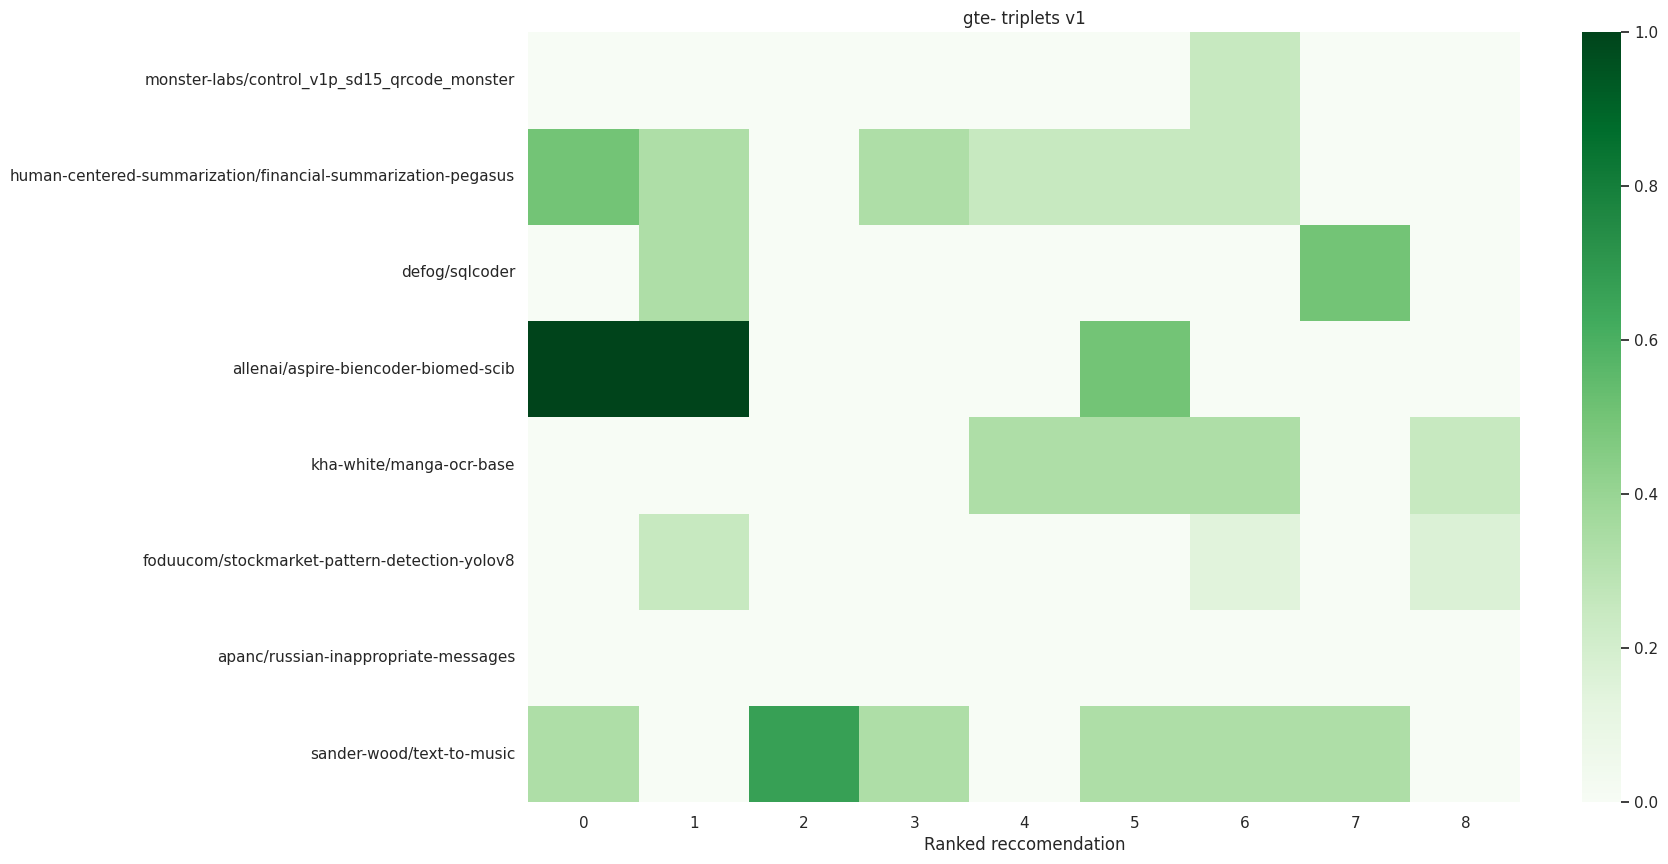

<ipython-input-26-1c2615ae6b7e>:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-26-1c2615ae6b7e>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-26-1c2615ae6b7e>:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



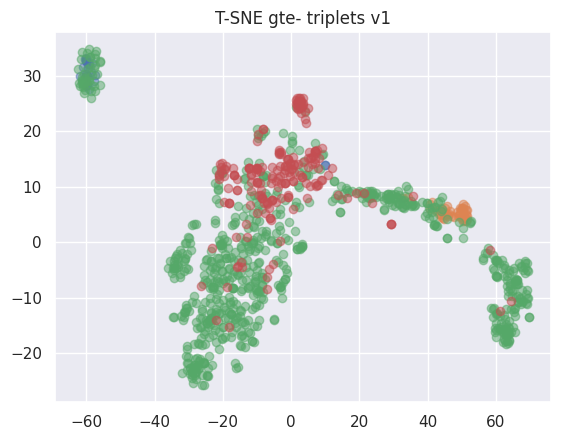

<ipython-input-26-1c2615ae6b7e>:43: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-26-1c2615ae6b7e>:44: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-26-1c2615ae6b7e>:45: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-26-1c26

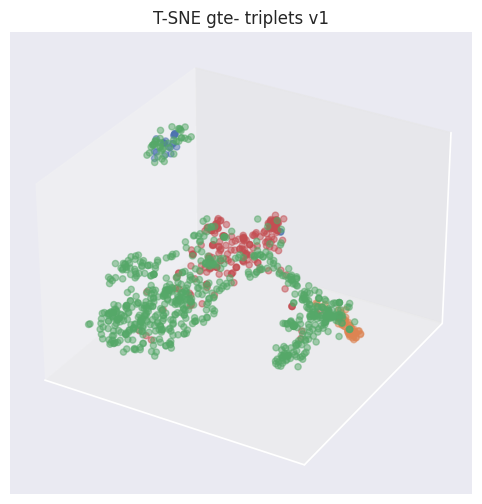

In [ ]:
run_full_eval_process(dict_embs["smart_triplets_last_one"][0], dict_embs["smart_triplets_last_one"][1],"gte- triplets v1")


Passages: 33511


Batches:   0%|          | 0/1048 [00:00<?, ?it/s]

  0%|          | 0/33511 [00:00<?, ?it/s]

dcg has failed


Model monster-labs/control_v1p_sd15_qrcode_monster:
coreml-community/coreml-anything-v5_cn
lint/old_anime_controlnets
coreml-community/coreml-qgo-10b
CyberHarem/megumin_konosuba
coreml-community/coreml-ghostmix-v11
Model human-centered-summarization/financial-summarization-pegasus:
Danish-summarisation/DanSumT5-pilot
Danish-summarisation/DanSumT5-large
ELiRF/mt5-base-dacsa-es
heack/HeackMT5-ZhSum100k
mrm8488/t5-base-finetuned-summarize-news
Model defog/sqlcoder:
microsoft/tapex-large-finetuned-wikisql
microsoft/tapex-large-sql-execution
microsoft/tapex-large-finetuned-wtq
DominikLindorfer/SQL-LLaMA
richardr1126/spider-natsql-wizard-coder-merged
Model allenai/aspire-biencoder-biomed-scib:
allenai/aspire-biencoder-biomed-spec
allenai/aspire-biencoder-compsci-spec
allenai/aspire-contextualsentence-singlem-biomed
allenai/aspire-contextualsentence-singlem-compsci
allenai/aspire-contextualsentence-multim-biomed
Model kha-white/manga-ocr-base:
Teklia/pylaia-home-alcar
Teklia/pylaia-huginmunin

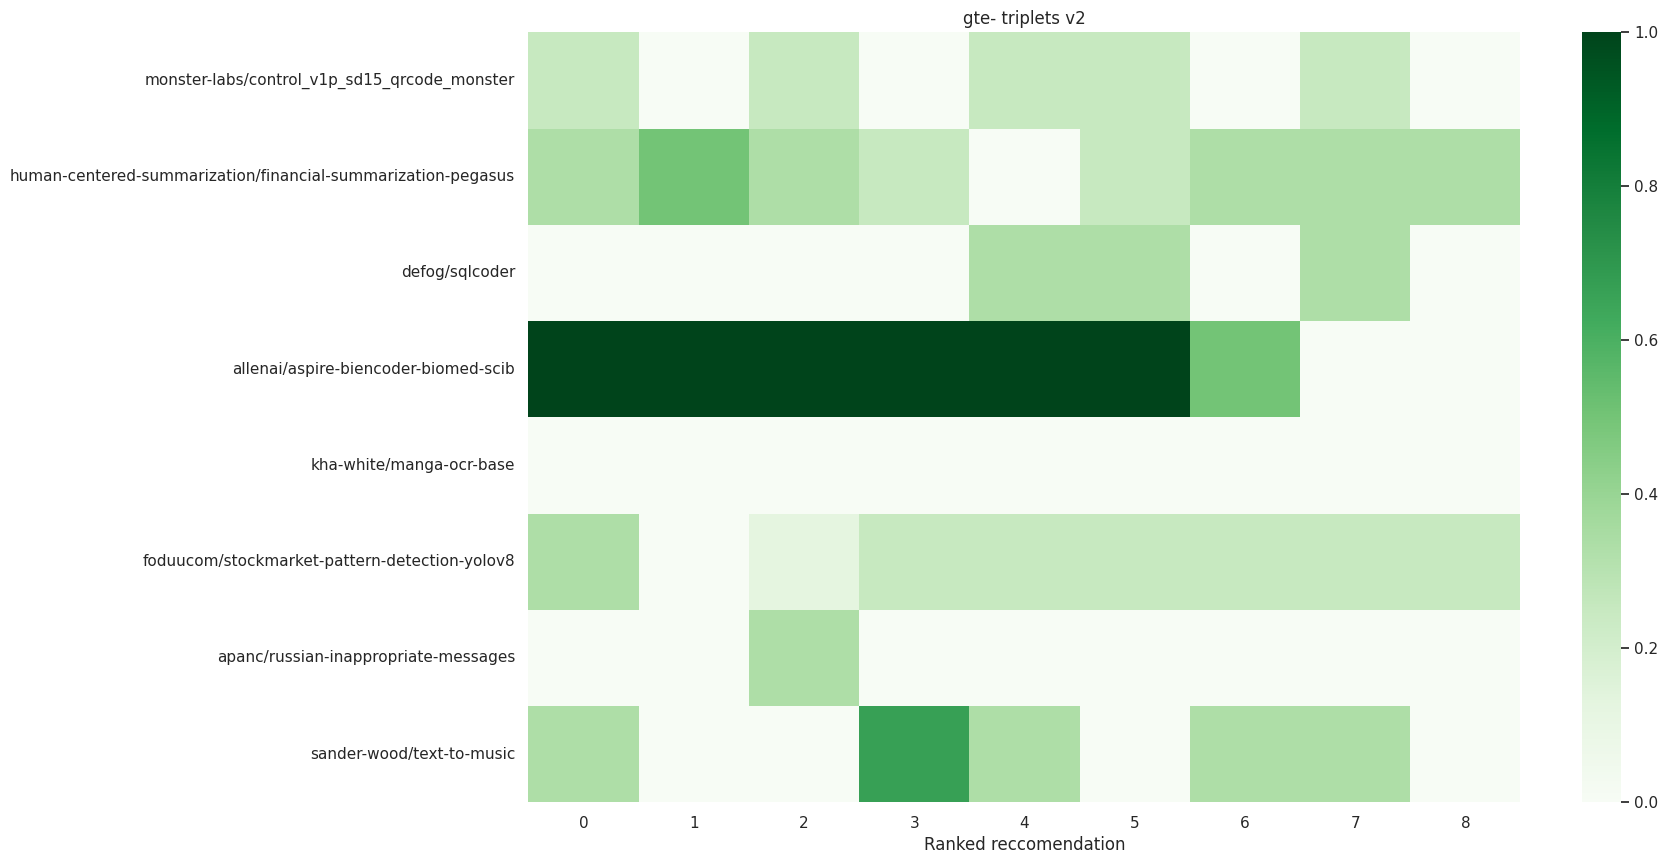

<ipython-input-26-1c2615ae6b7e>:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-26-1c2615ae6b7e>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-26-1c2615ae6b7e>:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



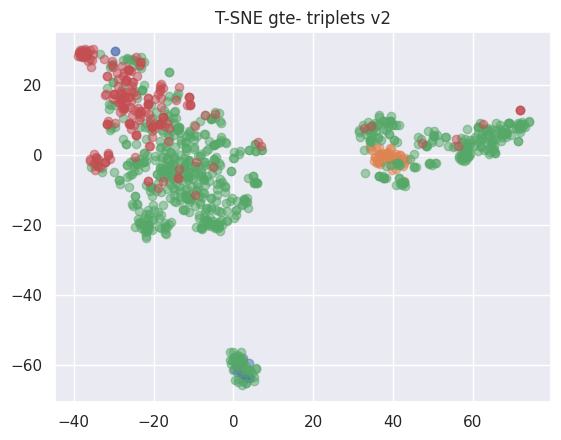

<ipython-input-26-1c2615ae6b7e>:43: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-26-1c2615ae6b7e>:44: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-26-1c2615ae6b7e>:45: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-26-1c26

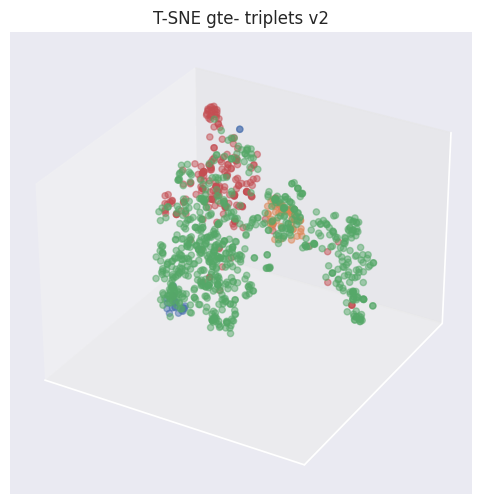

In [ ]:

run_full_eval_process(dict_embs["weighted_triplets_last_one"][0], dict_embs["weighted_triplets_last_one"][1],"gte- triplets v2")


Passages: 33511


Batches:   0%|          | 0/1048 [00:00<?, ?it/s]

  0%|          | 0/33511 [00:00<?, ?it/s]

dcg has failed


Model monster-labs/control_v1p_sd15_qrcode_monster:
DionTimmer/controlnet_qrcode
facebook/ic_gan
uukuguy/speechless-codellama-dolphin-orca-platypus-13b
speechlessai/speechless-codellama-dolphin-orca-platypus-13b
uukuguy/speechless-codellama-orca-airoboros-13b-0.10e
Model human-centered-summarization/financial-summarization-pegasus:
heack/HeackMT5-ZhSum100k
ChanceFocus/finma-7b-nlp
Joemgu/pegasus-x-sumstew
ChanceFocus/finma-7b-full
talalH/summarizer_on_T5_base
Model defog/sqlcoder:
gaussalgo/T5-LM-Large-text2sql-spider
qblocks/llama2_SQL_Answers_finetuned
DominikLindorfer/SQL-LLaMA
richardr1126/spider-natsql-wizard-coder-merged
NumbersStation/nsql-llama-2-7B
Model allenai/aspire-biencoder-biomed-scib:
allenai/aspire-biencoder-biomed-spec
allenai/aspire-biencoder-compsci-spec
allenai/aspire-contextualsentence-multim-biomed
allenai/aspire-contextualsentence-singlem-biomed
allenai/aspire-contextualsentence-multim-compsci
Model kha-white/manga-ocr-base:
priyank-m/m_OCR
microsoft/trocr-large

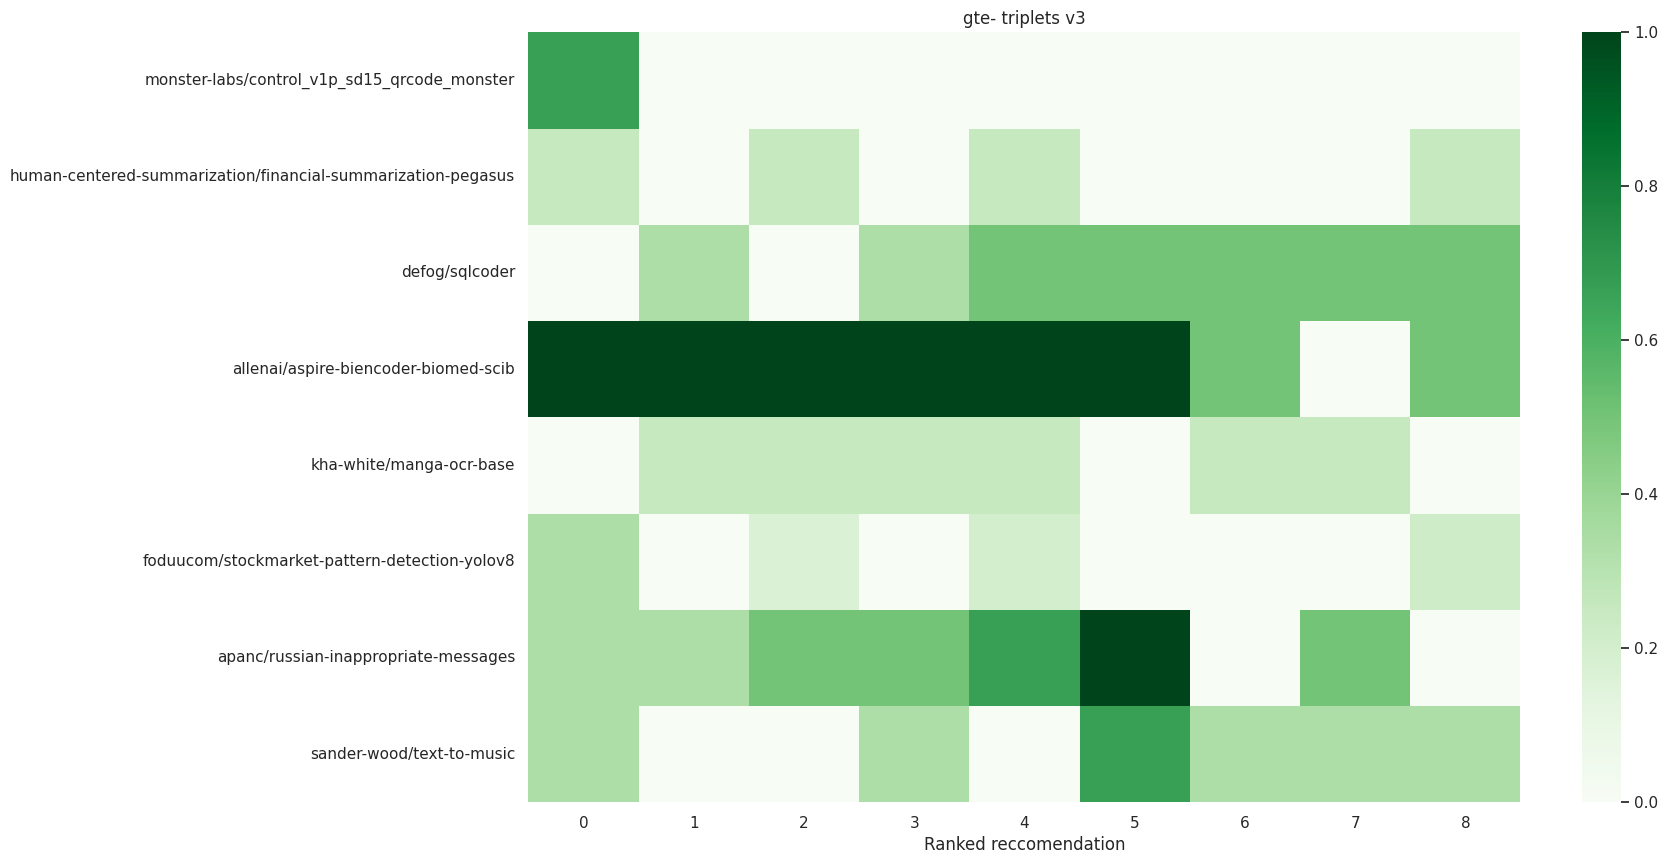

<ipython-input-26-1c2615ae6b7e>:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-26-1c2615ae6b7e>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-26-1c2615ae6b7e>:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



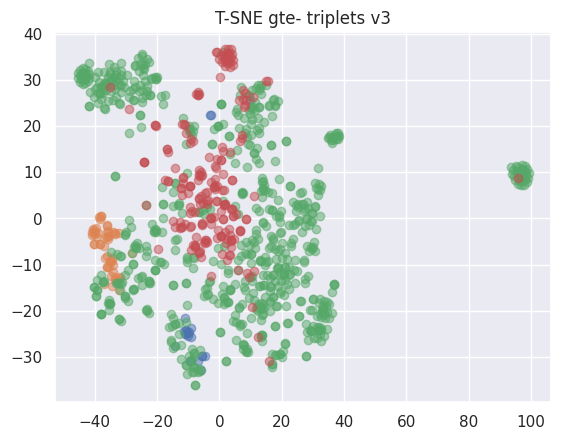

<ipython-input-26-1c2615ae6b7e>:43: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-26-1c2615ae6b7e>:44: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-26-1c2615ae6b7e>:45: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-26-1c26

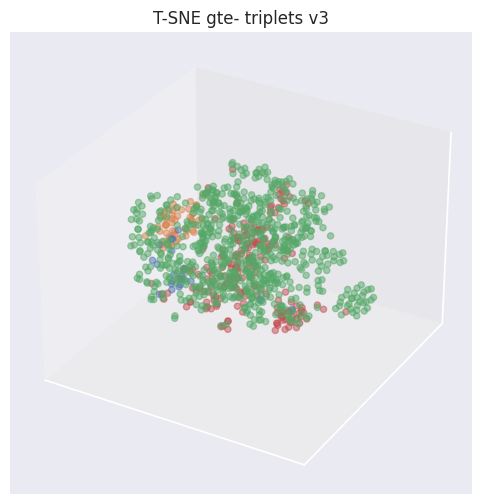

In [ ]:
run_full_eval_process(dict_embs["weighted_hard_triplets_last_one"][0], dict_embs["weighted_hard_triplets_last_one"][1],"gte- triplets v3")


In [ ]:
# run_full_eval_process(dict_embs["friday_triplets-half"][0], dict_embs["friday_triplets-half"][1],"gte - triplets v1 -500 iter")

In [ ]:
# run_full_eval_process(dict_embs["friday_weighted_triplets-half"][0], dict_embs["friday_weighted_triplets-half"][1],"gte - triplets v2 -500 iter")

In [ ]:
# run_full_eval_process(dict_embs["friday_hard_triplets-half"][0], dict_embs["friday_hard_triplets-half"][1],"gte - triplets v3 -500 iter")

In [ ]:
# run_full_eval_process(dict_embs["friday_weighted_triplets"][0], dict_embs["friday_weighted_triplets"][1],"gte - triplets v2")

In [ ]:
# run_full_eval_process(dict_embs["friday_hard_triplets"][0], dict_embs["friday_hard_triplets"][1],"gte - triplets v3")

Passages: 33511


Batches:   0%|          | 0/1048 [00:00<?, ?it/s]

  0%|          | 0/33511 [00:00<?, ?it/s]

dcg has failed


Model monster-labs/control_v1p_sd15_qrcode_monster:
natsusakiyomi/IrisMix
JosefJilek/AAT-JPEG-Artefact-Detection
teasan/EverDream
philschmid/donut-base-finetuned-cord-v2
coreml-community/coreml-qgo-10b
Model human-centered-summarization/financial-summarization-pegasus:
ErezR/FinanceNews
ELiRF/NASES
ELiRF/NASCA
Danish-summarisation/DanSumT5-pilot
Yale-LILY/brio-xsum-cased
Model defog/sqlcoder:
gaussalgo/T5-LM-Large-text2sql-spider
bugdaryan/Code-Llama-2-13B-instruct-text2sql
microsoft/tapex-large-finetuned-wikisql
tscholak/2jrayxos
DominikLindorfer/SQL-LLaMA
Model allenai/aspire-biencoder-biomed-scib:
allenai/aspire-biencoder-biomed-spec
allenai/aspire-biencoder-compsci-spec
allenai/aspire-contextualsentence-singlem-biomed
allenai/aspire-contextualsentence-singlem-compsci
allenai/aspire-contextualsentence-multim-biomed
Model kha-white/manga-ocr-base:
Teklia/pylaia-huginmunin
Teklia/pylaia-home-alcar
Teklia/pylaia-huginmunin-postprocessed
microsoft/trocr-large-stage1
Teklia/pylaia-fraktu

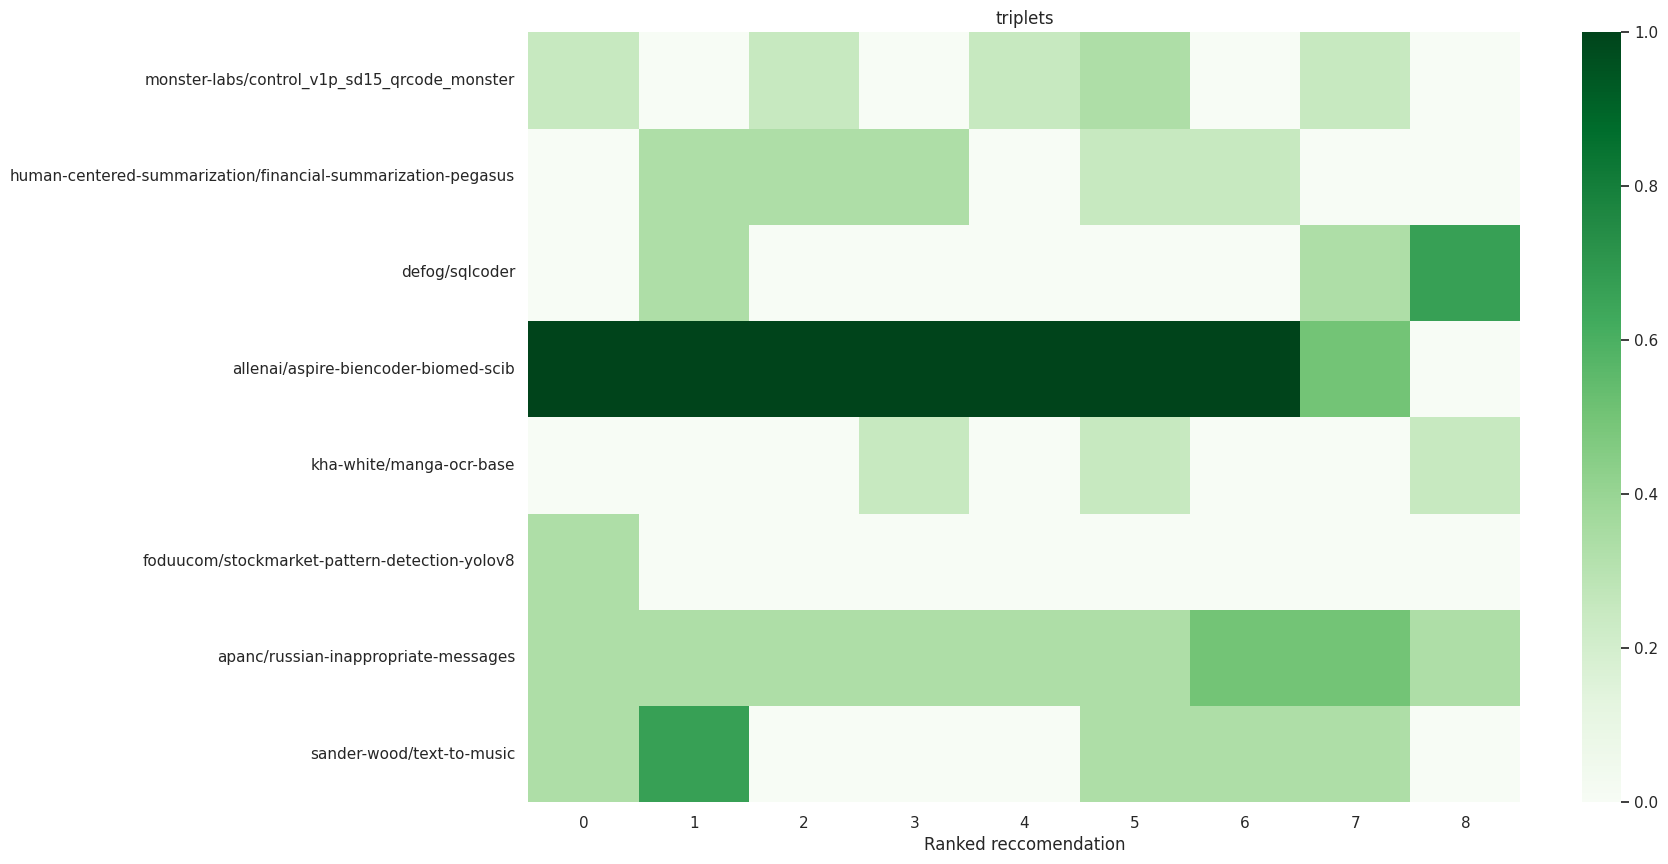

<ipython-input-26-1c2615ae6b7e>:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-26-1c2615ae6b7e>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-26-1c2615ae6b7e>:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



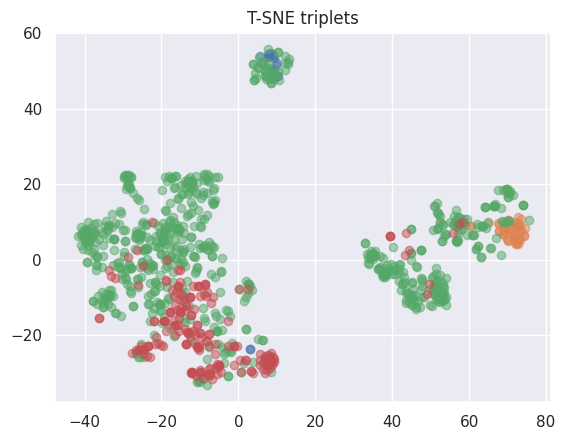

<ipython-input-26-1c2615ae6b7e>:43: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-26-1c2615ae6b7e>:44: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-26-1c2615ae6b7e>:45: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-26-1c26

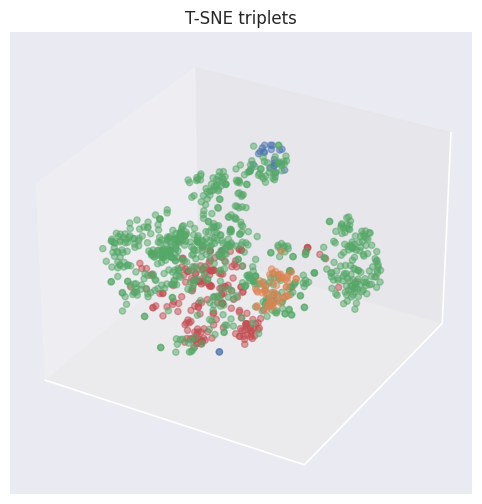

In [ ]:
run_full_eval_process(dict_embs["smart_triplets"][0], dict_embs["smart_triplets"][1],"triplets")

Passages: 33511


Batches:   0%|          | 0/1048 [00:00<?, ?it/s]

  0%|          | 0/33511 [00:00<?, ?it/s]

dcg has failed


Model monster-labs/control_v1p_sd15_qrcode_monster:
coreml-community/coreml-qgo-10b
coreml-community/coreml-cyberrealistic-v14
coreml-community/coreml-cyberrealistic-v32_cn
coreml-community/coreml-anything-v5_cn
coreml-community/coreml-xxmix9realistic_v26
Model human-centered-summarization/financial-summarization-pegasus:
ELiRF/NASES
ELiRF/NASCA
Danish-summarisation/DanSumT5-pilot
mrm8488/t5-base-finetuned-summarize-news
ELiRF/mt5-base-dacsa-es
Model defog/sqlcoder:
microsoft/tapex-large-finetuned-wikisql
microsoft/tapex-large-finetuned-wtq
microsoft/tapex-large-sql-execution
tscholak/2jrayxos
gaussalgo/T5-LM-Large-text2sql-spider
Model allenai/aspire-biencoder-biomed-scib:
allenai/aspire-biencoder-biomed-spec
allenai/aspire-biencoder-compsci-spec
allenai/aspire-contextualsentence-singlem-biomed
allenai/aspire-contextualsentence-singlem-compsci
allenai/aspire-contextualsentence-multim-biomed
Model kha-white/manga-ocr-base:
Teklia/pylaia-home-alcar
Teklia/pylaia-huginmunin
ussari/lora-t

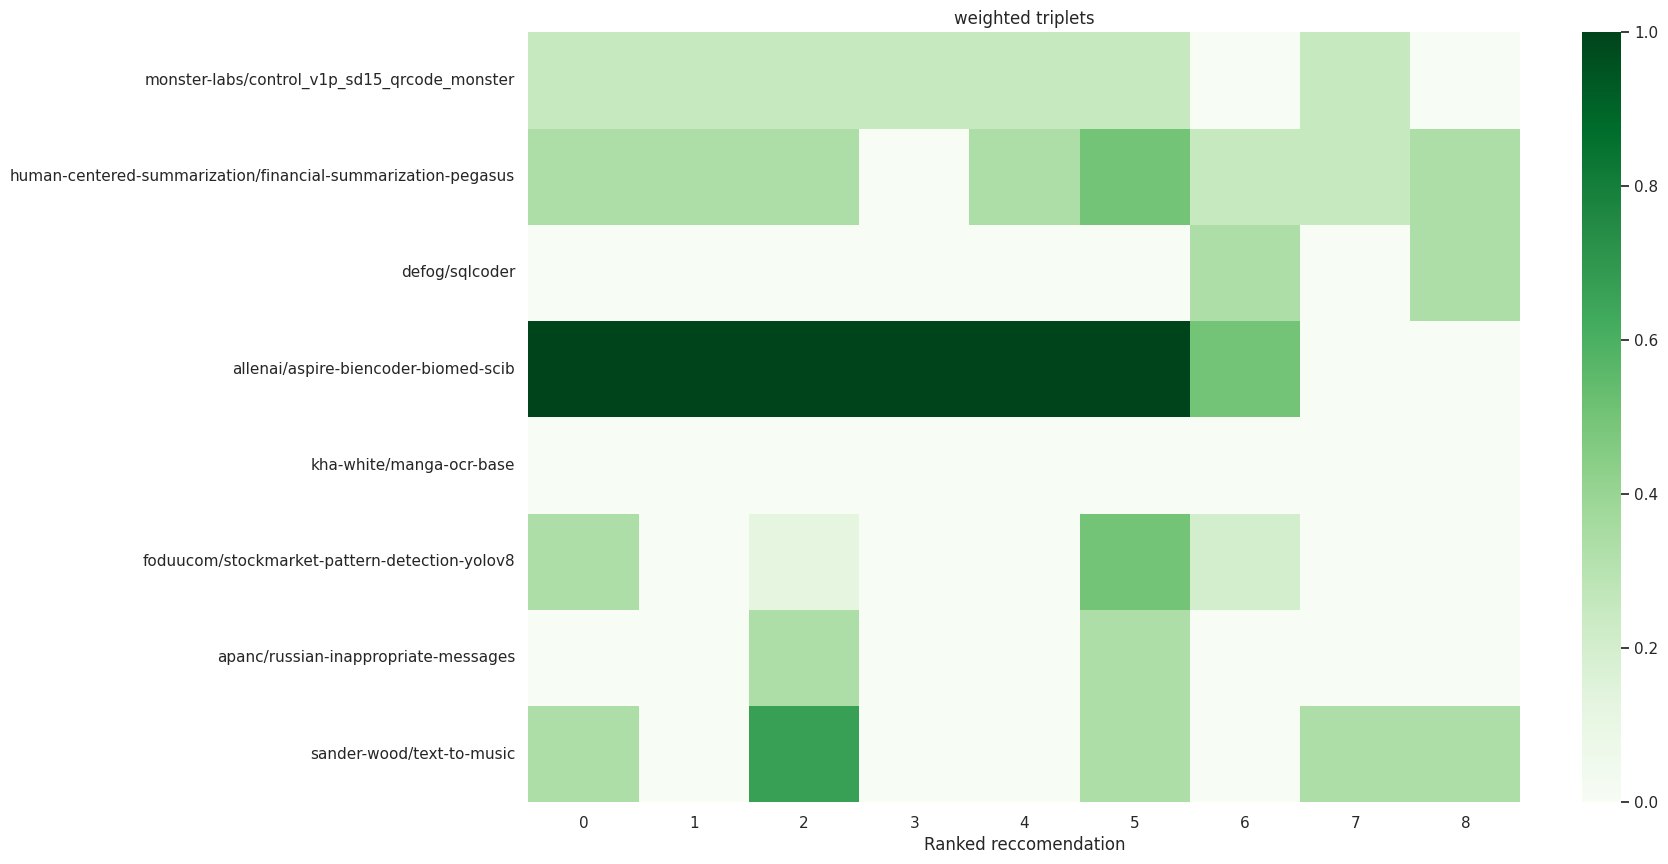

<ipython-input-26-1c2615ae6b7e>:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-26-1c2615ae6b7e>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-26-1c2615ae6b7e>:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



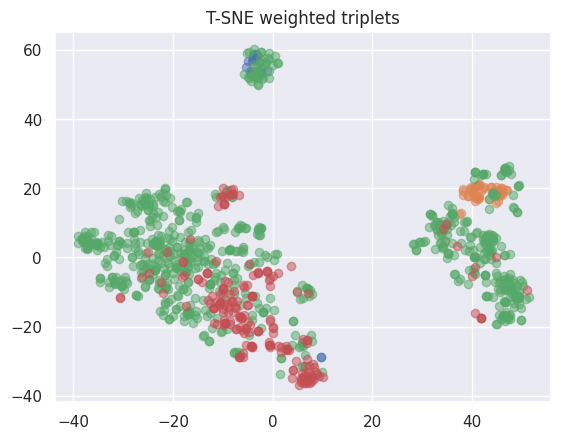

<ipython-input-26-1c2615ae6b7e>:43: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-26-1c2615ae6b7e>:44: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-26-1c2615ae6b7e>:45: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-26-1c26

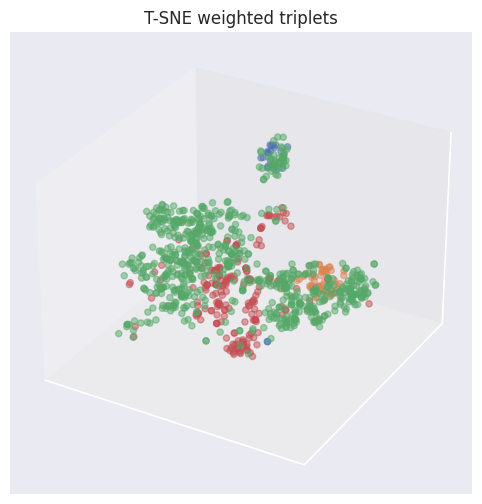

In [ ]:
run_full_eval_process(dict_embs["weighted_triplets"][0], dict_embs["weighted_triplets"][1],"weighted triplets")

Passages: 33511


Batches:   0%|          | 0/1048 [00:00<?, ?it/s]

  0%|          | 0/33511 [00:00<?, ?it/s]

dcg has failed


Model monster-labs/control_v1p_sd15_qrcode_monster:
MayaPH/GodziLLa2-70B
MayaPH/GodziLLa-30B
h2o-llmstudio/falcon-40b-fix
WizardLM/WizardLM-70B-V1.0
ichitaka/falcon-40b-instruct-8bit
Model human-centered-summarization/financial-summarization-pegasus:
huggingtweets/fidelity
huggingtweets/planetmoney
ChanceFocus/finma-7b-nlp
huggingtweets/marketsmeowmeow
MayaPH/FinOPT-Washington
Model defog/sqlcoder:
olivierdehaene/optimized-santacoder
patrickNLP/Graphix-3B
bigcode/starcoderplus
CarperAI/diff-codegen-2b-v2
bigcode/starcoderbase
Model allenai/aspire-biencoder-biomed-scib:
allenai/aspire-biencoder-biomed-spec
allenai/aspire-biencoder-compsci-spec
allenai/aspire-contextualsentence-singlem-biomed
allenai/aspire-contextualsentence-multim-biomed
allenai/aspire-contextualsentence-singlem-compsci
Model kha-white/manga-ocr-base:
svanhvit/byt5-ocr-post-processing-faroese
microsoft/markuplm-base
mindspore-ai/LeNet
Kosasih/Vxr-Z
beyond/genius-large-k2t
Model foduucom/stockmarket-pattern-detection-yo

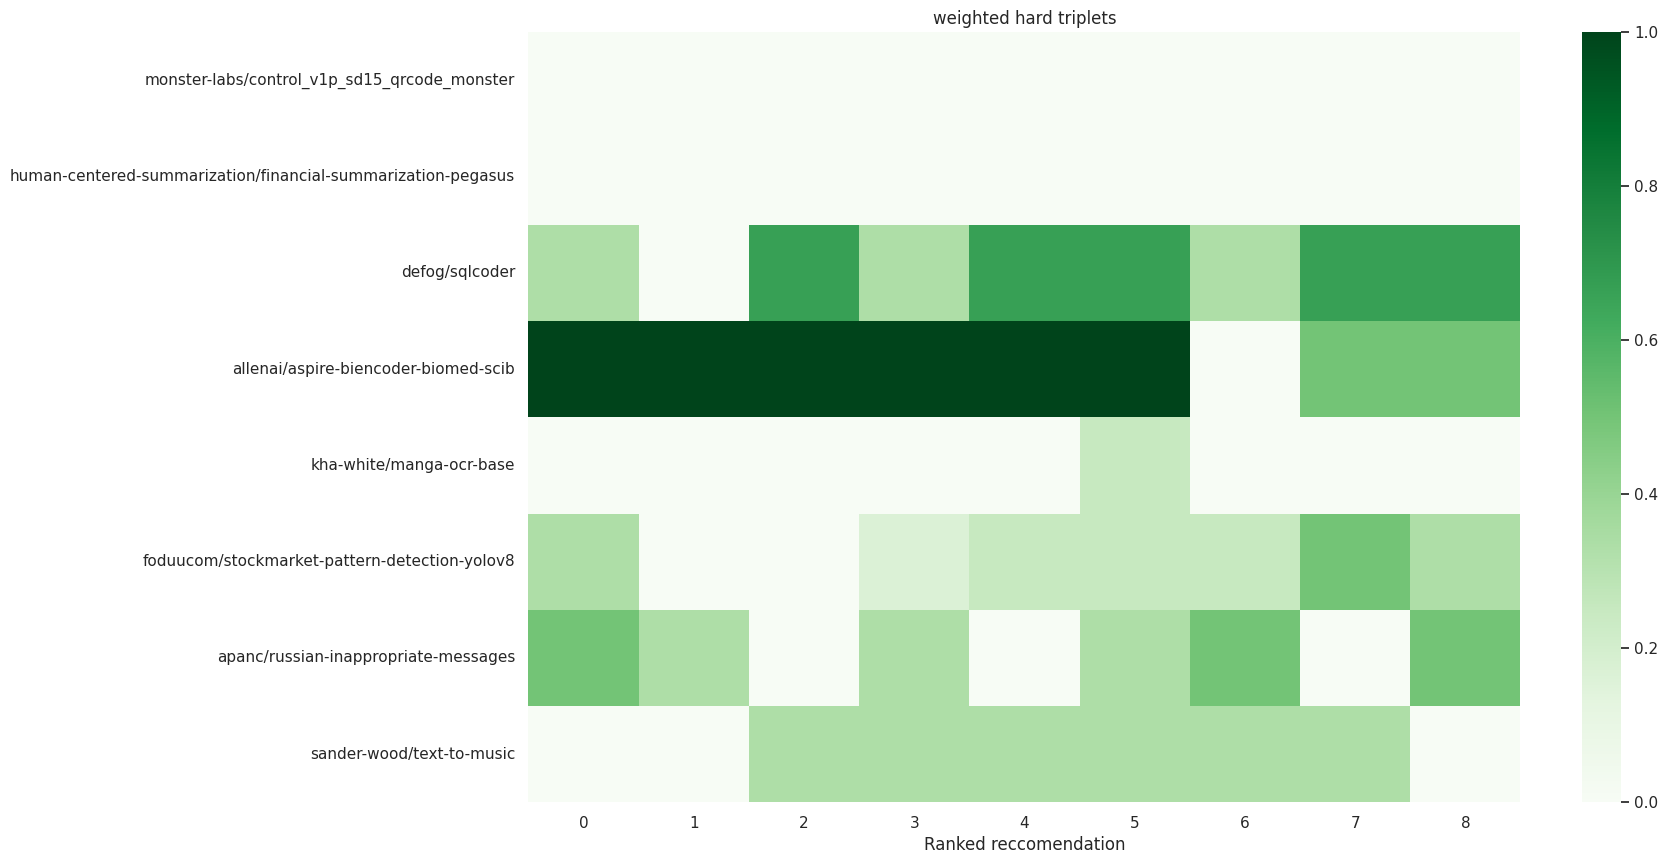

<ipython-input-26-1c2615ae6b7e>:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-26-1c2615ae6b7e>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-26-1c2615ae6b7e>:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



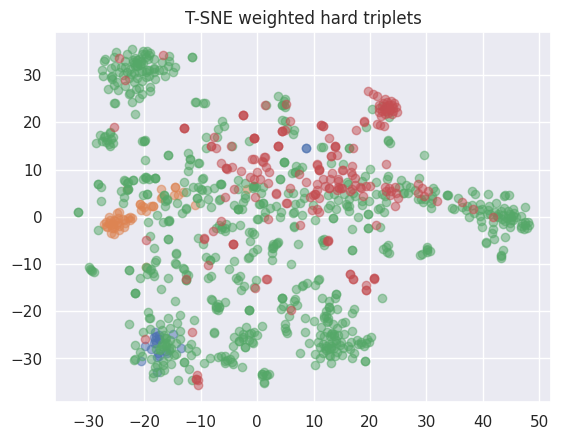

<ipython-input-26-1c2615ae6b7e>:43: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-26-1c2615ae6b7e>:44: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-26-1c2615ae6b7e>:45: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-26-1c26

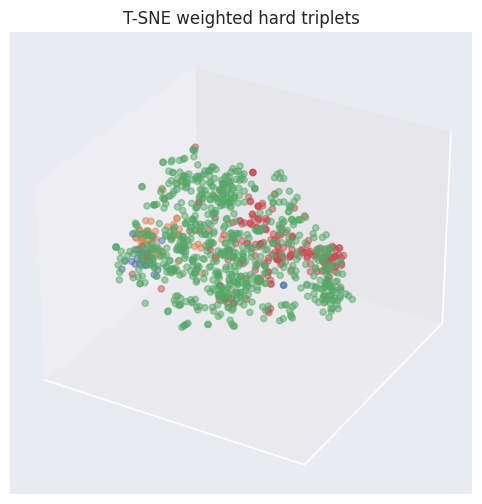

In [ ]:
run_full_eval_process(dict_embs["weighted_hard_triplets"][0], dict_embs["weighted_hard_triplets"][1],"weighted hard triplets")

In [ ]:
run_full_eval_process(dict_embs["triplets_reduced_driver_1"][0], dict_embs["triplets_reduced_driver_1"][1], "triplets")

In [ ]:
run_full_eval_process(dict_embs["weighted_triplets_reduced_driver_2"][0], dict_embs["weighted_triplets_reduced_driver_2"][1], "weighted_triplets")

In [ ]:
run_full_eval_process(dict_embs["hard_triplets_reduced_driver_3"][0], dict_embs["hard_triplets_reduced_driver_3"][1] , "hard_triplets")

In [ ]:
# data.iloc[:2500,:]["pipeline_tag"].value_counts()